## Solar project

### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Data Loading

In [2]:
# Loading data

generation = pd.read_csv('Plant_1_Generation_Data.csv', sep=';')
weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

Datas for the first week of June was mistakenly interpreted by to_datetime: day was replaced by month and vice versa. There was a necesity to define which of them is first, like below.

In [3]:
generation['DATE_TIME'] = pd.to_datetime(generation['DATE_TIME'], dayfirst = [False])

At first let's see the amount of produced energy over a given period of time. To this there is necesity to convert power to energy - in this case to divide it by 4. The amount of energy will be cumulated for days.

In [4]:
sumarised_generation = generation.groupby(['DATE_TIME'], sort=False).sum().reset_index()
sumarised_generation['DATE_TIME'] = pd.to_datetime(sumarised_generation['DATE_TIME'])
weather['DATE_TIME'] = pd.to_datetime(weather['DATE_TIME'])

sumarised_generation.drop(columns=['PLANT_ID'], inplace=True)

### 3. Preparing DataFrame

Sumarised data of all inverters was merged in one DataFrame with weather data, like below.

In [5]:
z = sumarised_generation.merge(weather, on='DATE_TIME')
z.drop(columns=['PLANT_ID', 'SOURCE_KEY'], inplace=True)

To calculate the amount of produced energy there is a necesity to calculate 1 hour data stamp, not 15 minutes one, because we need to calculate energy unit 1 kWh which is 1 kW (power unit) per hour.

In [6]:
sumarised_generation['ENERGY'] = sumarised_generation['AC_POWER']/4
sumarised_generation['DATE'] = pd.to_datetime(sumarised_generation['DATE_TIME']).dt.date

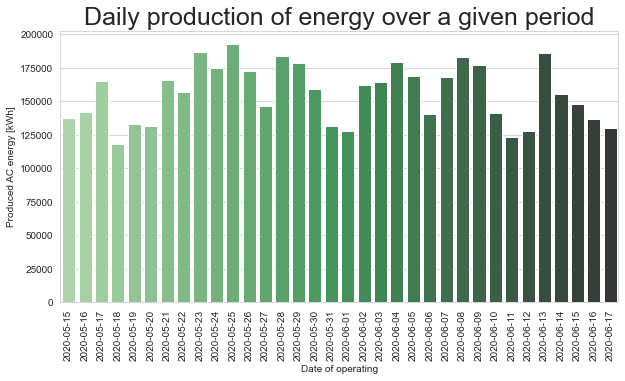

In [7]:
sns.set_style("whitegrid")

fig, total_production = plt.subplots(figsize=(10,5))
total_production = sns.barplot(x = "DATE", y = "ENERGY",
                              data = sumarised_generation,
                              estimator = sum,
                              ci = None,
                              palette = "Greens_d")

total_production.set(xlabel='Date of operating', ylabel='Produced AC energy [kWh]')
plt.title('Daily production of energy over a given period', fontsize=25)
plt.xticks(rotation=90)

plt.show()

In the picture above it is visible that everyday's amount of produced energy is diferent. In the next parts of this project I will try to discover reasons of that fact - dependencies of operating on weather conditions.

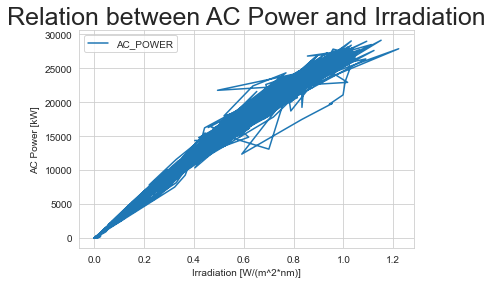

In [8]:
plot2 = z.plot('IRRADIATION', 'AC_POWER')
plot2.set(xlabel='Irradiation [W/(m^2*nm)]', ylabel='AC Power [kW]')
plt.title('Relation between AC Power and Irradiation', fontsize=25)
plt.show()

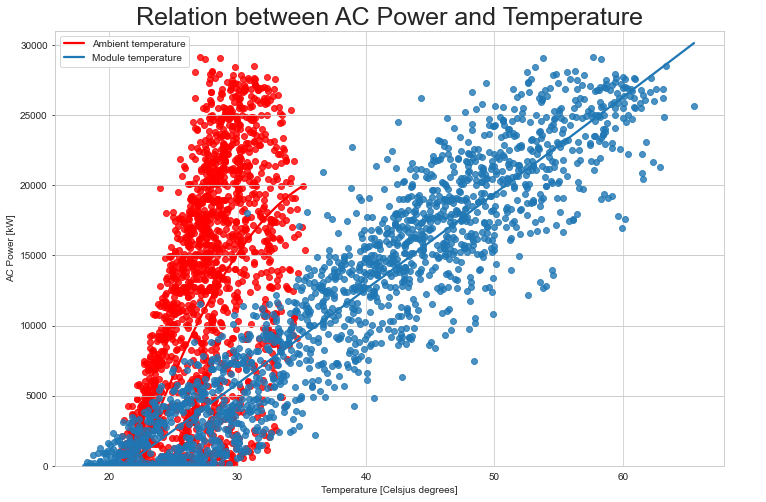

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
ax2 = ax.twinx()
sns.regplot(x="AMBIENT_TEMPERATURE", y="AC_POWER", data=z, order=2, ax=ax, color='red', ci = None)
sns.regplot(x="MODULE_TEMPERATURE", y="AC_POWER", data=z, order=2, ax=ax2, ci = None)


ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Ambient temperature", "Module temperature"])

plt.title('Relation between AC Power and Temperature', fontsize=25)
ax.set(xlabel='Temperature [Celsjus degrees]', ylabel='AC Power [kW]')
ax2.set(ylabel='')
ax.set_ylim(0,31000)
ax2.set_ylim(0,31000)
ax2.tick_params(axis='y', colors='white')
plt.show()

#delete regression from the plot and change legend

In [283]:
z.describe()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,ENERGY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3157.000000,3157.000000,3157.000000,3.157000e+03,3157.000000,3157.000000,3157.000000,3157.000000
mean,68560.019625,6704.830534,71798.457968,1.520288e+08,1676.207633,25.560257,31.175453,0.230103
std,88055.843520,8604.217954,65979.013517,1.038196e+07,2151.054489,3.351059,12.272685,0.301348
min,0.000000,0.000000,0.000000,2.654004e+07,0.000000,20.398505,18.140415,0.000000
25%,0.000000,0.000000,90.732143,1.521018e+08,0.000000,22.739895,21.130249,0.000000
50%,8430.196429,814.880357,66068.000000,1.535336e+08,203.720089,24.680324,24.801971,0.027748
75%,140409.892856,13752.112500,129444.625000,1.549952e+08,3438.028125,27.941221,41.449481,0.451576
max,298937.785710,29150.212499,193770.000000,1.561428e+08,7287.553125,35.252486,65.545714,1.221652
